This is also known as SEC-SAXS. In addition to x-ray scattering, data are typically also collected on the detectors on the HPLC system, at a constant frame rate during the elution process. At LiX beamline, all these data are packed into the h5 file. The `h5sol_HPLC` class provides access to these data and methods for data processing. While the GUI helps to adjust processing parameters interactively, the example below demonstrates how it can be done by code to provide more control.

In [1]:
%matplotlib inline

from lixtools.hdf import h5sol_HPLC
from lixtools.notebooks import display_HPLC_data,HPLC_GUI_par
from lixtools.notebooks.sol_hplc_mcr import performMCR
import pylab as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

This dataset has been processed already. Also to minimize the files size, the raw scattering data have been removed. We will first load the azimuthally averaged data and visualize the chromotogram based on x-ray scattering as well as a detector from the HPLC system.

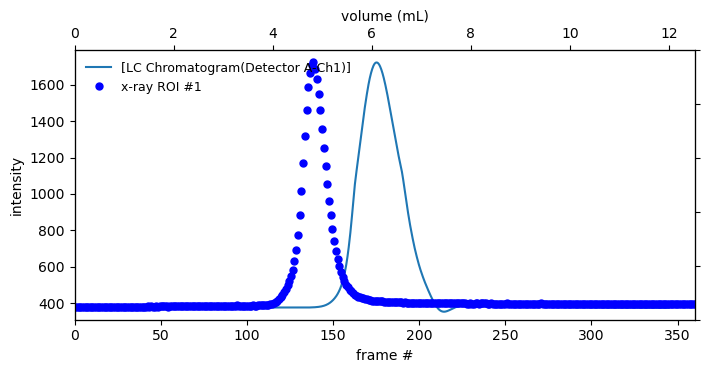

In [2]:
dt = h5sol_HPLC("data/BSAs_20mg.h5")
dt.load_d1s()

dt.plot_data(plot_merged=True, plot2d=False)

As in static measurements, the scattering from the buffer needs to be subtracted. This may not be constant 
in time. There could be a drift of baseline related to the purification system. And material accumulation on the flow cell window may introduce a rise in background scattering across the elution peak. Buffer subtraction can be performed using a few different methods. 

#### Use the average over a range of frames as buffer scattering

The simplest method is to use the averaged scattering data within a frame/time range (frame # 70-100 in the example below) away 
from the protein peak for subtraction. 
This usually works. However, when there is a rise of background scattering as the protein peak passes through the flow cell, 
the subtracted data may be contaminated by this contribution if frames before the peak are used as buffer scattering. Or conversely,
there could be over subtraction at low-$q$ if frames after the protein peak are used as buffer scattering.

averaging data with BSA_20mg-mergedf00070: 
 

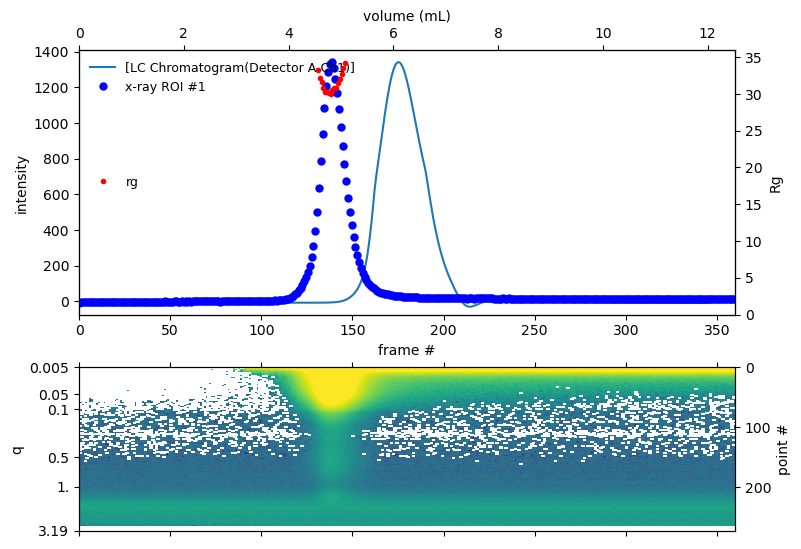

In [3]:
dt.subtract_buffer("70-100", sc_factor=0.997)
dt.plot_data(calc_Rg=True, thresh=600)

####
#### Use time-dependent components to reproduce buffer scattering 

To account for the time-dependence of the background scattering, or the baseline in the chromatogram, we previously described a 
[method](https://onlinelibrary.wiley.com/iucr/doi/10.1107/S1600577520002362) using 
singular value decomposition (SVD) ro extrapolate buffer scattering to under the protein peak. A modified version using non-negative matric factorization (NMF) is shown here.

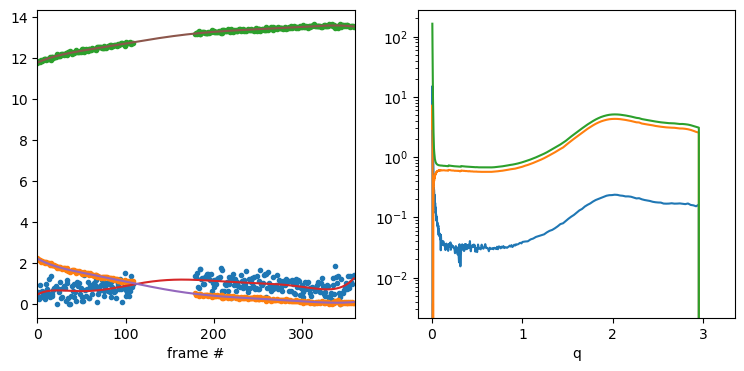

In [10]:
fig,axs = plt.subplots(ncols=2, figsize=(9,4))
dt.subtract_buffer_NMF("109-179", sc_factor=0.997, Nc=3,
                       fit_with_polynomial=True, poly_order=7,
                       #fit_with_polynomial=False, smoothing_factor=5,
                       ax1=axs[0], ax2=axs[1], plot_fit=True)

First, the buffer scattering is defined by excluding the range where the protein peak is observed (frame # 109-179). The data is 
then decomposed into `Nc` components, shown on the right. The coefficients of these components, as functions of frame # and plotted 
on the left above, are then extrapolated using either polynomial fits or
splines, to estimate the intensity of buffer scattering under the protein peak. In addition, the scaling factor for buffer subtraction, 
which is related to the volume fraction, is scaled based on the scattering intensity at low-$q$ before subtraction.

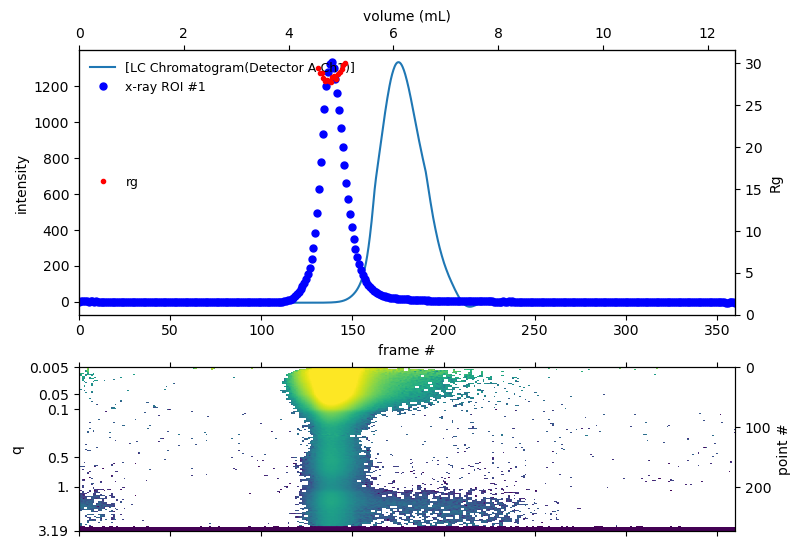

In [11]:
dt.plot_data(calc_Rg=True, thresh=600)

####
#### Include buffer scattering in component separation 

This is work in progress. Separating overlapping components in the scattering data that correspond to different molecular structures that cannot be 
fully resolved in chromatography is a general problem. The basic idea here is to include the buffer scattering, as well as the change in the 
empty cell scattering, as components in the separation problem.